Inspriation: [Quelle](https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad)<br>
Daten: [Quelle](https://github.com/kitsamho/songlyrics_univeral_sentence_encoder/tree/master/Lyric_data)


## Imports

In [178]:
%pip install -r requirements.txt
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import to_categorical




import random
# Random Seed setzen:
random.seed(49)
np.random.seed(49)
SEED = 49


label_encoder = LabelEncoder()

  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0
    Uninstalling python-dateutil-2.9.0:
      Successfully uninstalled python-dateutil-2.9.0
Note: you may need to restart the kernel to use updated packages.


## Load Data

In [179]:
df = pd.read_csv('lyrics.csv', encoding='ISO-8859-1')
df.head(3)

artist                            song  \
0  Katy Perry  The One That Got Away acoustic   
1  Katy Perry             Who Am I Living For   
2  Katy Perry                         Daisies   

                                              lyrics genre  lyric_count  \
0  summer after high school, when we first met we...   pop          221   
1  yeah, yeah, yeah i can feel a phoenix inside o...   pop          190   
2  told them your dreams and they all started lau...   pop          157   

   lyric_count_norm  
0          7.489217  
1          6.438694  
2          5.320394

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            3288 non-null   object 
 1   song              3282 non-null   object 
 2   lyrics            3288 non-null   object 
 3   genre             3288 non-null   object 
 4   lyric_count       3288 non-null   int64  
 5   lyric_count_norm  3288 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 154.3+ KB


Lyrics (Data) und Genere (Label) haben keinen Nullwert. Song (-Titel) fehelen 6 aber dass ist egal die können ignoriert werden.

In [181]:
df.describe()

lyric_count  lyric_count_norm
count  3288.000000       3288.000000
mean    219.480231          7.437716
std     151.992051          5.150686
min       1.000000          0.033888
25%     135.000000          4.574861
50%     182.000000          6.167591
75%     249.000000          8.438078
max    1623.000000         55.000000

- **lyric_count**: Mit der split-Funktion wird die Lyric in ihre einzelnen Wörter (auch Kommas?) geteilt und dann mit len-Funktion angezeigt. Sprich die Anzahl an Wörtern im Songtext.
- **lyric_count_norm**: Dieses Feature entsteht, indem jeder Eintrag in der Spalte lyric_count mit dem max. aus lyric_count dividiert wird. So entsteht eine normalisierter Wert von lyric_count. Daraufhin wird dieser Wert der sich zwischen 1 und 0 befindet mit dem Wert 55 multipliziert. So entsteht ein neuer Wert in der Spalte lyric_count_norm. Der Wert wird sozusagen wieder hochskaliert.

- [Link zur Analyse der Daten](https://www.notion.so/Notizen-Ivan-10-04-2024-8ba4890572db452a91ded46a5a276060)

Meines erachten nichts relevantes ablesbar

## Utils

Funktion zum Plotten der Modell History

In [182]:
# Helper function to plot the history of a model
def plot_history(history):
    print(history.history.keys())
    epochs = range(1, len(history.history['accuracy']) + 1)
    # summarize history for accuracy
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validation accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(loc='upper left')
    plt.show()
    # summarize history for loss, start from second epoch, cause the first is always too high
    plt.plot(epochs[1:], history.history['loss'][1:], 'o-', label='Training loss')
    plt.plot(epochs[1:], history.history['val_loss'][1:], 'o-', label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs[1:])  # Adjust x-axis to start from second epoch
    plt.legend(loc='upper left')
    plt.show()

## EDL und Preprocessing

Text(0.5, 1.0, 'The distribution of genres')

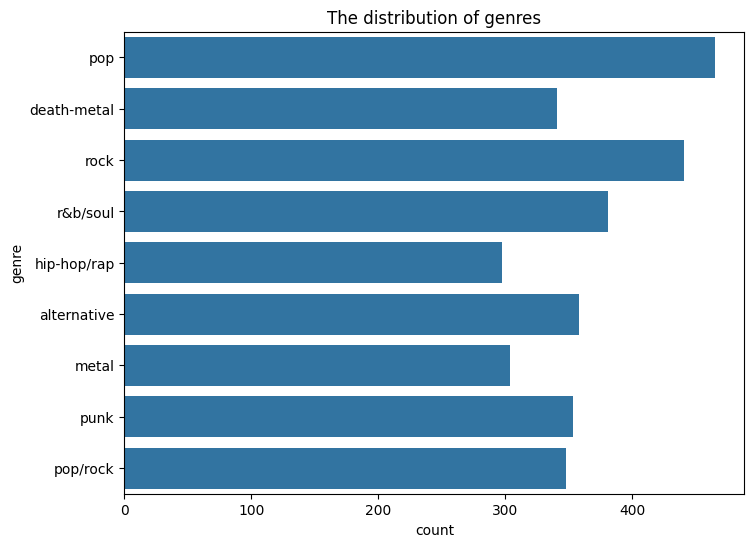

In [183]:
plt.figure(figsize=(8,6))
sns.countplot(df.genre)
plt.title('The distribution of genres')

Genres sehen erst Mal relativ gleichmäßig verteilt aus. Eventuell Später alle auf die ANzahl vom niedrigsten (Hip-Hop) kürzen 

Erstellen des numerischen Labels aus den Genres: 

In [184]:
df['label'] = label_encoder.fit_transform(df['genre'])
df.head()

artist                            song  \
0  Katy Perry  The One That Got Away acoustic   
1  Katy Perry             Who Am I Living For   
2  Katy Perry                         Daisies   
3  Katy Perry                         Witness   
4  Katy Perry                      Starstrukk   

                                              lyrics genre  lyric_count  \
0  summer after high school, when we first met we...   pop          221   
1  yeah, yeah, yeah i can feel a phoenix inside o...   pop          190   
2  told them your dreams and they all started lau...   pop          157   
3  if i lost it all today, would you stay? could ...   pop          233   
4  nice legs, daisy dukes makes a man go that is ...   pop          171   

   lyric_count_norm  label  
0          7.489217      4  
1          6.438694      4  
2          5.320394      4  
3          7.895872      4  
4          5.794824      4

Train/Test-Split:

In [185]:
x_train, x_test, y_train, y_test = train_test_split(df['lyrics'], df['label'], test_size=0.2, random_state=SEED, shuffle=True)

Tokenization:
The Tokenizer API from TensorFlow Keras can split sentences into words and encode them into integers.

The Tokenizer will perform all the necessary pre-processing steps:

- tokenize into word character (word level)
- num_words for maximum number of unique tokens
- filter out the punctuation terms
- convert all words to lower case
- convert all words to integer index

[Quelle](https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad)


In [186]:
# Defining pre-processing parameters
max_len = 182 # Das 2 Quartil genommen von oben lyrics_count
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

- num_words : how many unique word that we want to load in training and testing data
- oov_token : out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls.

[Quelle](https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad)


In [187]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

22848

The next step : Let’s represent each sentence by sequences of numbers using texts_to_sequencesfrom Tokenizer object. After that, we padded the sequence so that we can have same length of each sequence.
[Quelle](https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad)


Traindata:

In [188]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

Testdata:

In [189]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

- padding : ‘pre’ or ‘post (default pre). By using pre, we’ll pad before each sequence and post will pad after each sequence.
- maxlen : maximum length of all sequences. If not provided, by default it will use the maximum length of the longest sentence.
- truncating : ‘pre’ or ‘post’ (default ‘pre’). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. ‘pre’ option will truncate at the beginning where as ‘post’ will truncate at the end of the sequences.

In [190]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (2630, 182)
Shape of testing tensor:  (658, 182)


## Modells

### Dense Model

Build Modell:

In [191]:
# Define parameter
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24

num_classes = df['label'].nunique() # Anzahl an Genres (für Softmax layer die Klassen)

# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim))
                    #,input_length = max_len''))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_14     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training des Modells:

In [192]:
num_epochs = 150
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# One-hot encode labels damit es mit es mit der loss-Function funktioniert muss hotencoded werden
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

history = model.fit(training_padded,
                    y_train_encoded,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test_encoded),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/150


83/83 - 1s - 13ms/step - accuracy: 0.1878 - loss: 2.1766 - val_accuracy: 0.1657 - val_loss: 2.1675
Epoch 2/150
83/83 - 0s - 1ms/step - accuracy: 0.1947 - loss: 2.1217 - val_accuracy: 0.1976 - val_loss: 2.1091
Epoch 3/150
83/83 - 0s - 1ms/step - accuracy: 0.2357 - loss: 2.0485 - val_accuracy: 0.2371 - val_loss: 2.0378
Epoch 4/150
83/83 - 0s - 1ms/step - accuracy: 0.2567 - loss: 1.9730 - val_accuracy: 0.2705 - val_loss: 1.9591
Epoch 5/150
83/83 - 0s - 2ms/step - accuracy: 0.2779 - loss: 1.9219 - val_accuracy: 0.2964 - val_loss: 1.9074
Epoch 6/150
83/83 - 0s - 2ms/step - accuracy: 0.2958 - loss: 1.8758 - val_accuracy: 0.3085 - val_loss: 1.8711
Epoch 7/150
83/83 - 0s - 2ms/step - accuracy: 0.3046 - loss: 1.8478 - val_accuracy: 0.3176 - val_loss: 1.8331
Epoch 8/150
83/83 - 0s - 1ms/step - accuracy: 0.3103 - loss: 1.8195 - val_accuracy: 0.3191 - val_loss: 1.8033
Epoch 9/150
83/83 - 0s - 2ms/step - accuracy: 0.3213 - loss: 1.7927 - val_accuracy: 0.3298 - val_loss: 1.7831
Epoch 10/150
83/83 - 

Evaluation:

In [193]:
model.evaluate(testing_padded, y_test_encoded)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.3782 - loss: 1.6038


[1.5640101432800293, 0.41033434867858887]

Plotting der History:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


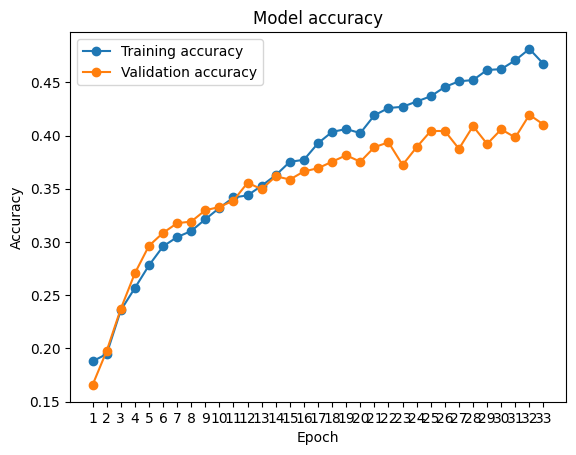

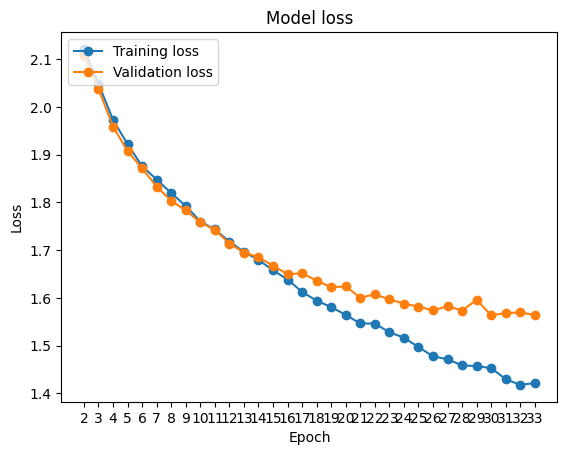

In [194]:
plot_history(history)

In [195]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train_encoded), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test_encoded), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

11/11 - 0s - 2ms/step - accuracy: 0.5243 - loss: 1.3449
3/3 - 0s - 6ms/step - accuracy: 0.4103 - loss: 1.5640
Train accuracy: 52.43
Valid accuracy: 41.03


TO-DO:
- Test und Validation muss getrennt werden.
- Modell muss optimiert werden

### LSTM Model

Build Modell:

In [196]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model 
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])


model1.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Modell training:

In [197]:
num_epochs1 = 30
early_stop1 = EarlyStopping(monitor='val_loss', patience=2)
history1 = model1.fit(training_padded,
                     y_train_encoded,
                     epochs=num_epochs1, 
                     validation_data=(testing_padded, y_test_encoded),
                     callbacks =[early_stop1],
                     verbose=2)

Epoch 1/30


83/83 - 6s - 76ms/step - accuracy: 0.1589 - loss: 2.1471 - val_accuracy: 0.1824 - val_loss: 2.1104
Epoch 2/30
83/83 - 4s - 54ms/step - accuracy: 0.1939 - loss: 2.0875 - val_accuracy: 0.2204 - val_loss: 2.0399
Epoch 3/30
83/83 - 4s - 53ms/step - accuracy: 0.2011 - loss: 2.0692 - val_accuracy: 0.2401 - val_loss: 1.9993
Epoch 4/30
83/83 - 5s - 54ms/step - accuracy: 0.2030 - loss: 2.0398 - val_accuracy: 0.1824 - val_loss: 2.0853
Epoch 5/30
83/83 - 4s - 54ms/step - accuracy: 0.2133 - loss: 2.0504 - val_accuracy: 0.2006 - val_loss: 2.0308


Plotting the results:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


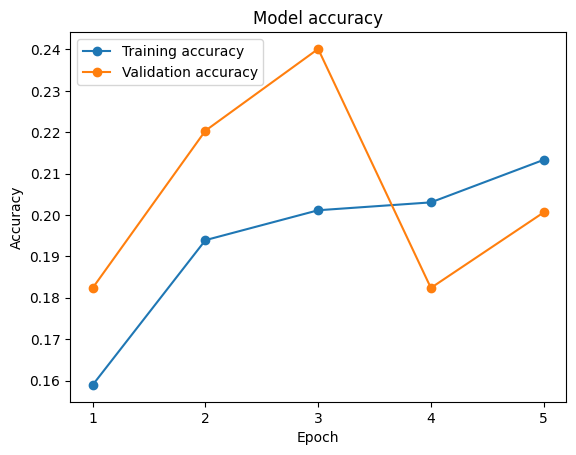

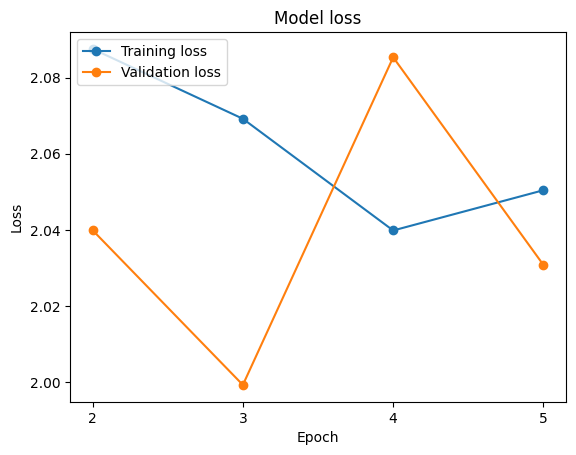

In [198]:
plot_history(history1)

Print der Accuracy

In [199]:
train_dense_results1 = model1.evaluate(training_padded, np.asarray(y_train_encoded), verbose=2, batch_size=256)
valid_dense_results1 = model1.evaluate(testing_padded, np.asarray(y_test_encoded), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

11/11 - 1s - 71ms/step - accuracy: 0.2198 - loss: 1.9976
3/3 - 0s - 70ms/step - accuracy: 0.2006 - loss: 2.0308
Train accuracy: 52.43
Valid accuracy: 41.03


TO-DO:
- Test und Validation muss getrennt werden.
- Modell muss optimiert werden

### Bi-LSTM Model

Modell Setup:

In [200]:
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(num_classes, activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

model2.summary()

c:\USERS\IVAN\MINICONDA3\ENVS\NLP\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Modell Training:

In [201]:
num_epochs2 = 30
early_stop2 = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history2 = model2.fit(training_padded,
                     y_train_encoded,
                     epochs = num_epochs2,
                     validation_data = (testing_padded, y_test_encoded),
                     callbacks = [early_stop2],
                     verbose = 2)

Epoch 1/30
83/83 - 8s - 101ms/step - accuracy: 0.1951 - loss: 2.0953 - val_accuracy: 0.2371 - val_loss: 2.0514
Epoch 2/30
83/83 - 6s - 67ms/step - accuracy: 0.2608 - loss: 1.9527 - val_accuracy: 0.2553 - val_loss: 1.9490
Epoch 3/30
83/83 - 6s - 67ms/step - accuracy: 0.2821 - loss: 1.8954 - val_accuracy: 0.2644 - val_loss: 1.9375
Epoch 4/30
83/83 - 6s - 68ms/step - accuracy: 0.2837 - loss: 1.8593 - val_accuracy: 0.2584 - val_loss: 1.9478
Epoch 5/30
83/83 - 6s - 68ms/step - accuracy: 0.2802 - loss: 1.8526 - val_accuracy: 0.2994 - val_loss: 1.8191
Epoch 6/30
83/83 - 6s - 67ms/step - accuracy: 0.3011 - loss: 1.8044 - val_accuracy: 0.2736 - val_loss: 1.8331
Epoch 7/30
83/83 - 6s - 67ms/step - accuracy: 0.3148 - loss: 1.7517 - val_accuracy: 0.3283 - val_loss: 1.8051
Epoch 8/30
83/83 - 5s - 66ms/step - accuracy: 0.3327 - loss: 1.7169 - val_accuracy: 0.3100 - val_loss: 1.7948
Epoch 9/30
83/83 - 6s - 68ms/step - accuracy: 0.3399 - loss: 1.6787 - val_accuracy: 0.3161 - val_loss: 1.7482
Epoch 10/

Plot History:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


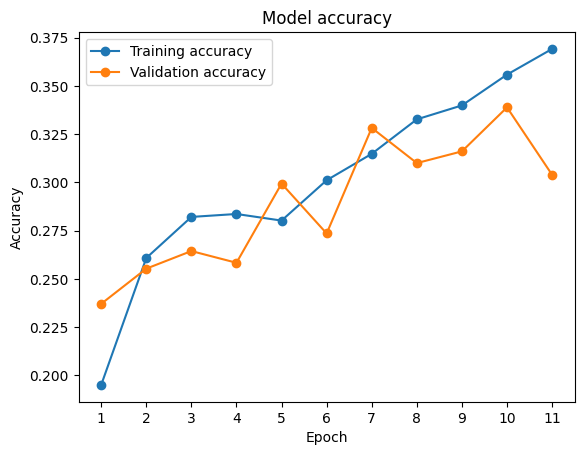

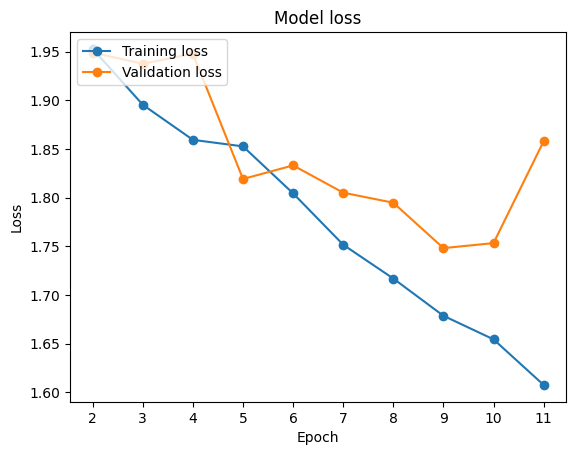

In [202]:
plot_history(history2)

Print der Accuracy:

In [203]:
train_dense_results2 = model2.evaluate(training_padded, np.asarray(y_train_encoded), verbose=2, batch_size=256)
valid_dense_results2 = model2.evaluate(testing_padded, np.asarray(y_test_encoded), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

11/11 - 1s - 80ms/step - accuracy: 0.3331 - loss: 1.7034
3/3 - 0s - 93ms/step - accuracy: 0.3040 - loss: 1.8578
Train accuracy: 52.43
Valid accuracy: 41.03


### Gated Recurrent Unit (GRU)

Modell Setup:

In [204]:
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(num_classes, activation='softmax'))
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])
model3.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Modell Training:

In [205]:
num_epochs3 = 30
early_stop3 = EarlyStopping(monitor='val_loss', patience=2)
history3 = model3.fit(training_padded,
                     y_train_encoded,
                     epochs=num_epochs3, 
                     validation_data=(testing_padded, y_test_encoded),
                     callbacks =[early_stop3],
                     verbose=2)

Epoch 1/30
83/83 - 7s - 81ms/step - accuracy: 0.1703 - loss: 2.1557 - val_accuracy: 0.2067 - val_loss: 2.0994
Epoch 2/30
83/83 - 5s - 55ms/step - accuracy: 0.1787 - loss: 2.1097 - val_accuracy: 0.1915 - val_loss: 2.0892
Epoch 3/30
83/83 - 5s - 55ms/step - accuracy: 0.1779 - loss: 2.1099 - val_accuracy: 0.1717 - val_loss: 2.0841
Epoch 4/30
83/83 - 5s - 55ms/step - accuracy: 0.1878 - loss: 2.0696 - val_accuracy: 0.1915 - val_loss: 2.0368
Epoch 5/30
83/83 - 5s - 56ms/step - accuracy: 0.2213 - loss: 2.0312 - val_accuracy: 0.2280 - val_loss: 2.0244
Epoch 6/30
83/83 - 5s - 54ms/step - accuracy: 0.2243 - loss: 1.9689 - val_accuracy: 0.2249 - val_loss: 2.0063
Epoch 7/30
83/83 - 4s - 54ms/step - accuracy: 0.2776 - loss: 1.8596 - val_accuracy: 0.2812 - val_loss: 1.8404
Epoch 8/30
83/83 - 4s - 54ms/step - accuracy: 0.3141 - loss: 1.7749 - val_accuracy: 0.2842 - val_loss: 1.8394
Epoch 9/30
83/83 - 4s - 54ms/step - accuracy: 0.3183 - loss: 1.7529 - val_accuracy: 0.3009 - val_loss: 1.7979
Epoch 10/3

Plot History:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


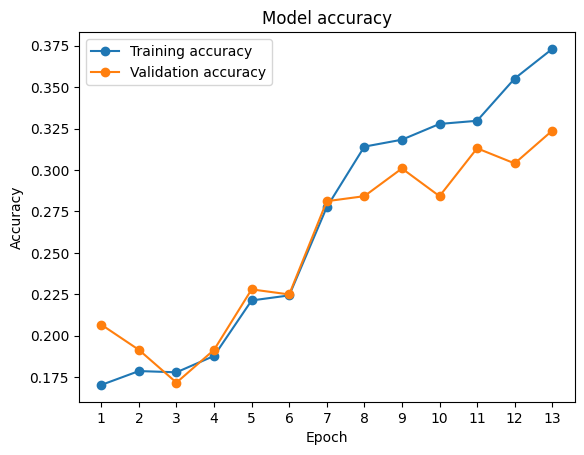

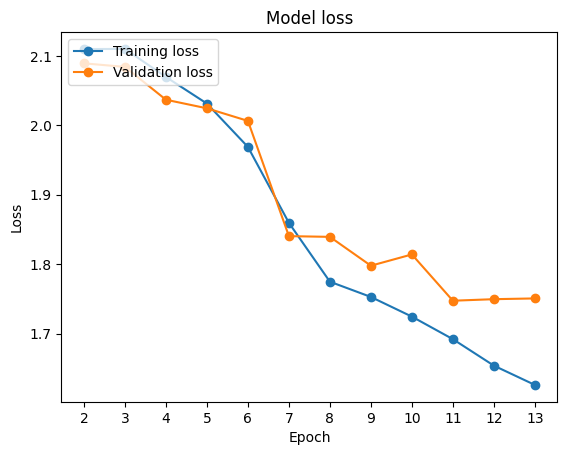

In [206]:
plot_history(history3)

Print der Accuracy:

In [207]:
train_dense_results3 = model3.evaluate(training_padded, np.asarray(y_train_encoded), verbose=2, batch_size=256)
valid_dense_results3 = model3.evaluate(testing_padded, np.asarray(y_test_encoded), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

11/11 - 1s - 57ms/step - accuracy: 0.4270 - loss: 1.5394
3/3 - 0s - 59ms/step - accuracy: 0.3237 - loss: 1.7508
Train accuracy: 52.43
Valid accuracy: 41.03


## Comparing Modells

In [211]:
# Comparing the four different models
print(f"Dense model loss and accuracy: {model.evaluate(testing_padded, y_test_encoded)} \n------------------------------------------------------------\n" )
print(f"LSTM model loss and accuracy: {model1.evaluate(testing_padded, y_test_encoded)} \n------------------------------------------------------------\n" )
print(f"Bi-LSTM model loss and accuracy: {model2.evaluate(testing_padded, y_test_encoded)} \n------------------------------------------------------------\n" )
print(f"GRU model loss and accuracy: {model3.evaluate(testing_padded, y_test_encoded)}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.3782 - loss: 1.6038
Dense model loss and accuracy: [1.5640101432800293, 0.41033434867858887] 
------------------------------------------------------------

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1921 - loss: 2.0318
LSTM model loss and accuracy: [2.0307729244232178, 0.20060789585113525] 
------------------------------------------------------------

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2999 - loss: 1.9249
Bi-LSTM model loss and accuracy: [1.8578401803970337, 0.3039513826370239] 
------------------------------------------------------------

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3014 - loss: 1.8167
GRU model loss and accuracy: [1.7507880926132202, 0.3237082064151764]


## Summary

Wir sehen aus dem vergleich der Modelle dass die modelle wie folgt abgeschnitten haben:
1. Platz: Dense
2. Platz: GRU
3. Platz: Bi-LSTM
4. Platz: LSTM

## Test with unseen data

TO-DO:
- Verschiedene Songs labeln lassen